In [5]:
import locale
import torch
locale.getpreferredencoding = lambda: "UTF-8"

In [62]:
!pip install onnx
!pip install onnxruntime
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.1/223.1 MB 4.5 MB/s eta 0:00:00


In [1]:
def install_onnxruntime():
    if torch.cuda.is_available():
        # Install ONNX Runtime GPU version
        subprocess.check_call([sys.executable, "-m", "pip", "install", "onnxruntime-gpu"])
        print("Installed onnxruntime-gpu for GPU execution.")
    else:
        # Install ONNX Runtime CPU version
        subprocess.check_call([sys.executable, "-m", "pip", "install", "onnxruntime"])
        print("Installed onnxruntime for CPU execution.")

In [4]:
install_onnxruntime()

Installed onnxruntime-gpu for GPU execution.


In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
from torchvision import models

import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import onnxruntime as ort
import subprocess
import sys

# Downloading dataset

In [2]:
!pip install kaggle

In [3]:
# Dowload image dataset for crash detection
!kaggle datasets download -d ckay16/accident-detection-from-cctv-footage

Dataset URL: https://www.kaggle.com/datasets/ckay16/accident-detection-from-cctv-footage
License(s): ODbL-1.0
 99% 247M/249M [00:15<00:00, 18.8MB/s]
100% 249M/249M [00:15<00:00, 16.6MB/s]


In [4]:
!unzip -q 'accident-detection-from-cctv-footage.zip' -d /content/dataset

In [21]:
# Dowload video dataset for car crashes
!kaggle datasets download -d fahaddalwai/cctvfootagevideo

Dataset URL: https://www.kaggle.com/datasets/fahaddalwai/cctvfootagevideo
License(s): CC-BY-NC-SA-4.0
100% 9.68M/9.68M [00:01<00:00, 11.4MB/s]
100% 9.68M/9.68M [00:01<00:00, 6.51MB/s]


In [22]:
!unzip -q 'cctvfootagevideo.zip' -d /content/dataset/videos

# Preprocessing

In [6]:
batch_size = 10
img_height = 224
img_width = 224

In [7]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),])

train_dir = '/content/dataset/data/train'
test_dir = '/content/dataset/data/test'
val_dir = '/content/dataset/data/val'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)


In [51]:

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


class_names = train_dataset.classes
print("Classes:", class_names)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")
print(f"Validation dataset: {len(val_dataset)} images")

Classes: ['Accident', 'Non Accident']
Train dataset: 791 images
Test dataset: 100 images
Validation dataset: 98 images


In [8]:
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")  # Should be [batch_size, channels, height, width]
    break

Batch image shape: torch.Size([10, 3, 224, 224])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
num_classes = len(train_dataset.classes)

In [11]:
# Load the pre-trained MobileNetV2 model
base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
base_model.features = nn.Sequential(*list(base_model.features.children()))  # Extract features part of MobileNetV2
base_model.classifier = nn.Identity()  # Remove the classifier (top) part of the model

In [12]:
# Freeze base model parameters
for param in base_model.parameters():
    param.requires_grad = False

In [13]:
# Define the custom model by adding a classifier on top of the base model
class CustomModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x


In [14]:
model = CustomModel(base_model, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [17]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    # Append to history
    history['train_loss'].append(epoch_loss)
    history['train_accuracy'].append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_running_loss += loss.item()

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = 100 * val_correct / val_total

    # Append to history
    history['val_loss'].append(val_epoch_loss)
    history['val_accuracy'].append(val_epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.2f}%")

Epoch [1/50], Train Loss: 0.6794, Train Accuracy: 56.76%, Val Loss: 0.5507, Val Accuracy: 71.43%
Epoch [2/50], Train Loss: 0.5619, Train Accuracy: 71.05%, Val Loss: 0.5143, Val Accuracy: 71.43%
Epoch [3/50], Train Loss: 0.5680, Train Accuracy: 72.57%, Val Loss: 0.4703, Val Accuracy: 74.49%
Epoch [4/50], Train Loss: 0.5511, Train Accuracy: 72.44%, Val Loss: 0.4453, Val Accuracy: 78.57%
Epoch [5/50], Train Loss: 0.4934, Train Accuracy: 75.73%, Val Loss: 0.4401, Val Accuracy: 80.61%
Epoch [6/50], Train Loss: 0.4660, Train Accuracy: 77.37%, Val Loss: 0.3991, Val Accuracy: 79.59%
Epoch [7/50], Train Loss: 0.4609, Train Accuracy: 77.50%, Val Loss: 0.4295, Val Accuracy: 80.61%
Epoch [8/50], Train Loss: 0.4822, Train Accuracy: 74.21%, Val Loss: 0.4050, Val Accuracy: 83.67%
Epoch [9/50], Train Loss: 0.4703, Train Accuracy: 77.37%, Val Loss: 0.3814, Val Accuracy: 85.71%
Epoch [10/50], Train Loss: 0.4406, Train Accuracy: 80.28%, Val Loss: 0.4198, Val Accuracy: 82.65%
Epoch [11/50], Train Loss: 0.

# Validation

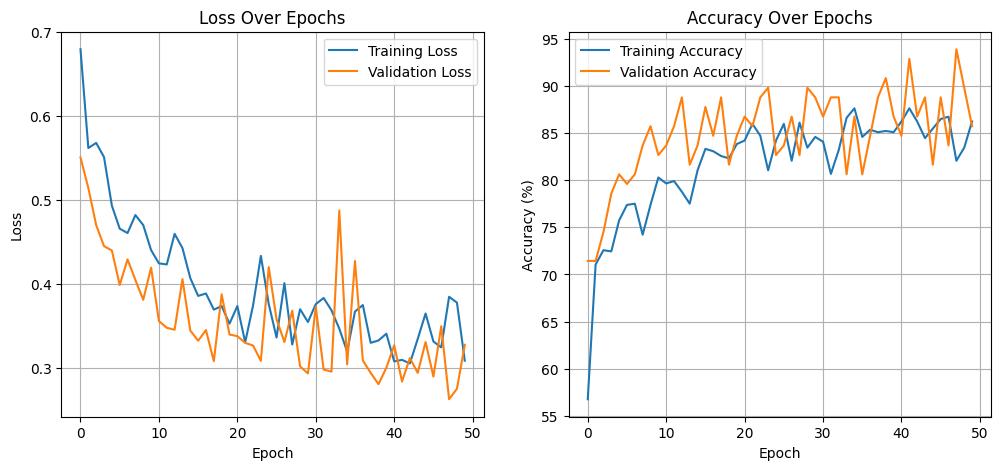

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.show()

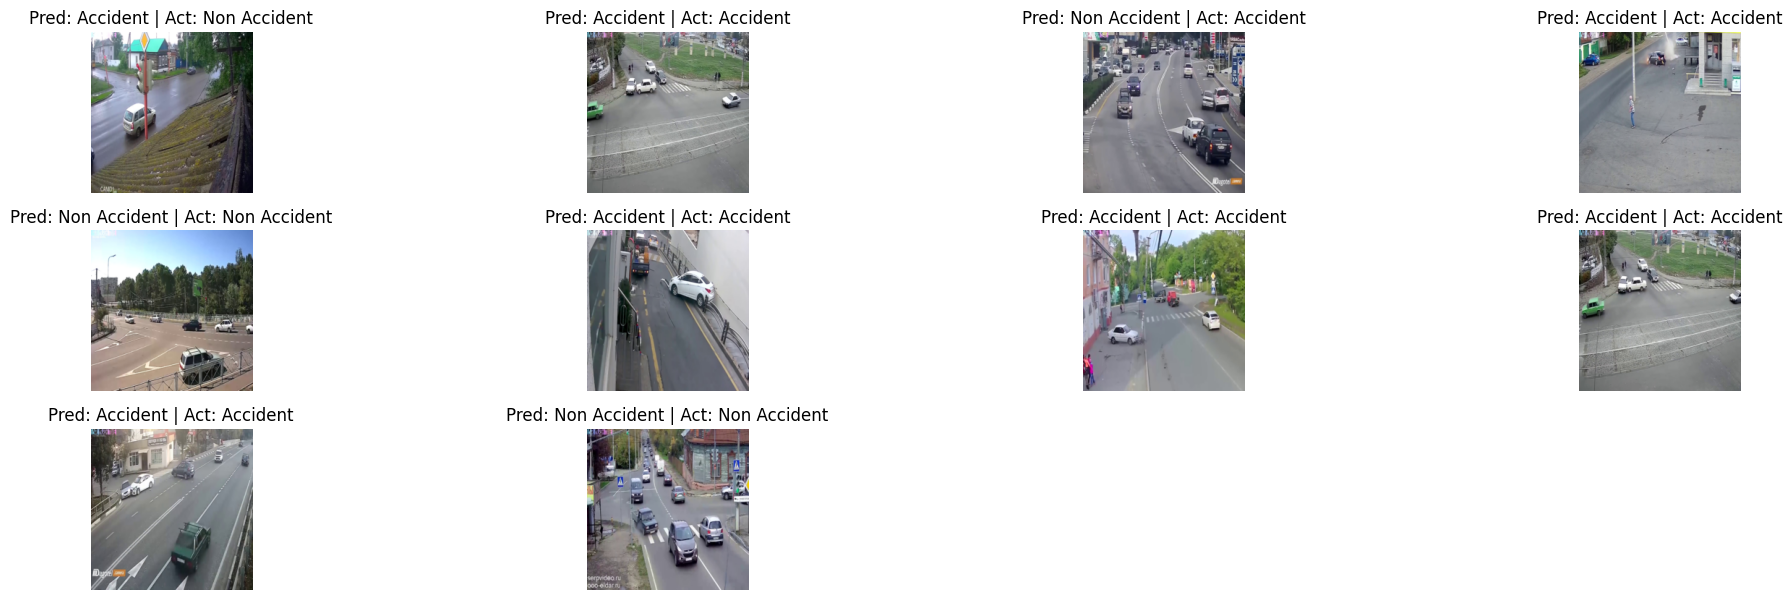

In [52]:
model.eval()


AccuracyVector = []
plt.figure(figsize=(20, 20))

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

predlabel = [class_names[p] for p in predicted]
actlabel = [class_names[l] for l in labels]

AccuracyVector = predicted == labels

# Visualize the first 40 images with predictions and actual labels
for i in range(min(40, len(images))):  # Limit to 40 images or the number of images in the batch (currently set at 10)
    ax = plt.subplot(10, 4, i + 1)
    img = images[i].cpu().permute(1, 2, 0).numpy()  # Convert image to CPU and format it for plotting
    img = (img * 255).astype(np.uint8)
    plt.imshow(img)
    plt.title(f'Pred: {predlabel[i]} | Act: {actlabel[i]}')
    plt.axis('off')
    plt.grid(False)

plt.tight_layout()
plt.show()

In [55]:
model.eval()

truePositive = 0
trueNegative = 0
falsePositive = 0
falseNegative = 0

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        predicted = predicted.cpu().numpy()
        labels = labels.cpu().numpy()

        truePositive += np.sum((predicted == 0) & (labels == 0))
        trueNegative += np.sum((predicted == 1) & (labels == 1))
        falsePositive += np.sum((predicted == 0) & (labels == 1))
        falseNegative += np.sum((predicted == 1) & (labels == 0))

        correct += np.sum(predicted == labels)
        total += labels.size

total_accuracy = 100 * correct / total


print(f'True positives (TP): {truePositive}')
print(f'True negatives (TN): {trueNegative}')
print(f'False positives (FP): {falsePositive}')
print(f'False negatives (FN): {falseNegative}')
print(f'Total accuracy: {total_accuracy:.2f}%')

True positives (TP): 44
True negatives (TN): 43
False positives (FP): 10
False negatives (FN): 3
Total accuracy: 87.00%


# Prediction on video

In [25]:
# Define transformations to resize and convert frames to tensors
transform = transforms.Compose([
    transforms.ToPILImage(),                      # Convert OpenCV image (NumPy array) to PIL (compatible with torch) image
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

In [26]:
# Function to predict the class of a frame using the trained model
def predict_frame(img, model):

    img_tensor = transform(img)
    img_batch = img_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_batch)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)

    # Return the prediction as a label
    if predicted_class.item() == 0:
        return "Accident Detected"
    else:
        return "No Accident"

In [27]:
images = []  # To store frames
labels = []  # To store predictions

frame_interval = 10  # Process every 10th frame
cap = cv2.VideoCapture('/content/dataset/videos/videoplayback (online-video-cutter.com).mp4')
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break


    if frame_count % frame_interval == 0:
        label = predict_frame(frame, model)
        images.append(frame)
        labels.append(label)
        # Stop after processing 75 frames
        if len(images) == 75:
            break

    frame_count += 1

cap.release()  # Release the video capture object


In [28]:
len(images)

75

Label for frame 20: Accident Detected


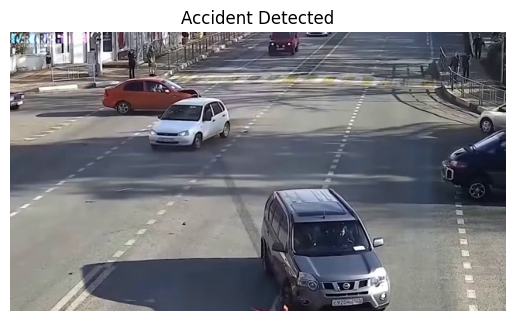

In [29]:
# Display a random frame and its predicted label
index = 20  # Choose any index from 0 to len(images) - 1
print(f"Label for frame {index}: {labels[index]}")
plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title(labels[index])
plt.axis('off')
plt.show()

# Converting to Torch script environment

In [30]:
model.eval()

# Convert the model to TorchScript using tracing or scripting
# Here, we use tracing for a simpler model
example_input = torch.rand(1, 3, img_height, img_width).to(device)  # Example input for tracing
traced_script_module = torch.jit.trace(model, example_input)

traced_script_module.save("torchscript_model.pt")

In [29]:
loaded_model = torch.jit.load("torchscript_model.pt")
loaded_model.to(device)

RecursiveScriptModule(
  original_name=CustomModel
  (base_model): RecursiveScriptModule(
    original_name=MobileNetV2
    (features): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Conv2dNormActivation
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=BatchNorm2d)
        (2): RecursiveScriptModule(original_name=ReLU6)
      )
      (1): RecursiveScriptModule(
        original_name=InvertedResidual
        (conv): RecursiveScriptModule(
          original_name=Sequential
          (0): RecursiveScriptModule(
            original_name=Conv2dNormActivation
            (0): RecursiveScriptModule(original_name=Conv2d)
            (1): RecursiveScriptModule(original_name=BatchNorm2d)
            (2): RecursiveScriptModule(original_name=ReLU6)
          )
          (1): RecursiveScriptModule(original_name=Conv2d)
          (2): RecursiveScriptModule(original_name=BatchNorm

In [36]:
# Example function to make predictions with the TorchScript model
def predict_with_torchscript(model, image_path):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make predictions using the loaded TorchScript model
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        confidence = probabilities[0, predicted_class].item()

    prediction_label = "Accident Detected" if predicted_class.item() == 0 else "No Accident"
    print(f"Prediction: {prediction_label} with confidence: {confidence:.2f}")
    plt.imshow(image)
    plt.title(f"{prediction_label} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

Prediction: Accident Detected with confidence: 0.69


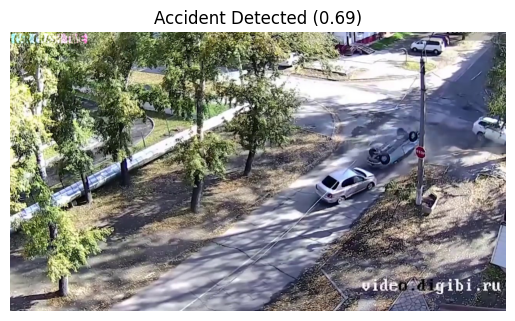

In [39]:
# Accident should be detected
predict_with_torchscript(loaded_model, "/content/dataset/data/test/Accident/test15_15.jpg")

Prediction: No Accident with confidence: 0.55


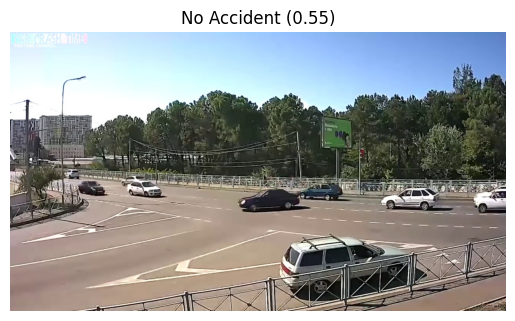

In [38]:
# Accident should not be detected
predict_with_torchscript(loaded_model, "/content/dataset/data/test/Non Accident/test11_12.jpg")

# Measuring model difference

In [41]:
torch.save(model.state_dict(), 'original_model.pth')

In [49]:
model = CustomModel(base_model, num_classes)
model.load_state_dict(torch.load('original_model.pth'))
model.to(device)

<ipython-input-49-b3cb169ca84f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('original_model.pth'))


CustomModel(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [15]:
original_model_size = os.path.getsize('/content/original_model.pth')
torchscript_model_size = os.path.getsize('/content/torchscript_model.pt')

print(f"Original PyTorch model size: {original_model_size / 1024:.2f} KB")
print(f"TorchScript model size: {torchscript_model_size / 1024:.2f} KB")

Original PyTorch model size: 8943.30 KB
TorchScript model size: 9290.72 KB


In [27]:
def measure_inference_time(model, image_tensor, iterations=100):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = model(image_tensor)
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / iterations
    print(f"Average inference time over {iterations} runs: {avg_inference_time:.6f} seconds")

In [47]:
image_tensor = torch.rand(1, 3, img_height, img_width).to(device)

In [48]:
# TorchScript model measurement
measure_inference_time(loaded_model, image_tensor)

Average inference time over 100 runs: 0.002386 seconds


In [49]:
# Original model time measurement
measure_inference_time(model, image_tensor)

Average inference time over 100 runs: 0.008532 seconds


## Measure ONNX

In [16]:
example_input = torch.rand(1, 3, img_height, img_width).to(device)

onnx_model_path = "model.onnx"
torch.onnx.export(
    model,
    example_input,
    onnx_model_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

original_model_size = os.path.getsize('original_model.pth')  #
torchscript_model_size = os.path.getsize('torchscript_model.pt')
onnx_model_size = os.path.getsize(onnx_model_path)

print(f"Original PyTorch model size: {original_model_size / 1024:.2f} KB")
print(f"TorchScript model size: {torchscript_model_size / 1024:.2f} KB")
print(f"ONNX model size: {onnx_model_size / 1024:.2f} KB")

Original PyTorch model size: 8943.30 KB
TorchScript model size: 9290.72 KB
ONNX model size: 8675.92 KB


In [17]:
# Define the function to load the ONNX model and configure execution provider
def create_onnx_session(onnx_model_path):
    # Check if CUDA (GPU) is available
    providers = ['CUDAExecutionProvider'] if torch.cuda.is_available() else ['CPUExecutionProvider']

    # Create ONNX Runtime session
    session = ort.InferenceSession(onnx_model_path, providers=providers)
    print(f"ONNX Runtime using provider: {session.get_providers()[0]}")
    return session

In [19]:
# Prepare the ONNX Runtime session
onnx_model_path = "/content/model.onnx"
session = create_onnx_session(onnx_model_path)

ONNX Runtime using provider: CUDAExecutionProvider


In [45]:
# Create a random tensor for benchmarking, matching the expected input shape and type
# Convert to NumPy array with float32, needed for ONNX
random_input_tensor = torch.rand(1, 3, img_height, img_width).numpy().astype(np.float32)

# Check the input details of the ONNX model to ensure correct input format
input_details = session.get_inputs()
input_name = input_details[0].name
input_shape = input_details[0].shape
input_type = input_details[0].type

# Replace dynamic 'batch_size' with 1 for inference
input_shape = [1 if isinstance(dim, str) else dim for dim in input_shape]

print(f"Expected input name: {input_name}, shape: {input_shape}, type: {input_type}")

# Ensure the input tensor shape and type match the model requirements
if random_input_tensor.shape != tuple(input_shape):
    print(f"Adjusting tensor shape to match model input shape: {tuple(input_shape)}")
    random_input_tensor = random_input_tensor.reshape(tuple(input_shape))

Expected input name: input, shape: [1, 3, 224, 224], type: tensor(float)


In [46]:
def measure_onnx_inference_time(session, input_tensor, iterations=100):
    input_name = session.get_inputs()[0].name
    start_time = time.time()
    for _ in range(iterations):
        _ = session.run(None, {input_name: input_tensor})
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / iterations
    print(f"Average inference time over {iterations} runs (ONNX): {avg_inference_time:.6f} seconds")

In [47]:
# Measure ONNX model inference time
measure_onnx_inference_time(session, random_input_tensor)

Average inference time over 100 runs (ONNX): 0.002551 seconds


In [36]:
# TorchScript model measurement
measure_inference_time(loaded_model, image_tensor)

Average inference time over 100 runs: 0.002559 seconds


In [35]:
# Original model time measurement
measure_inference_time(model, image_tensor)

Average inference time over 100 runs: 0.005731 seconds
